## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH']]
pums_data_p = p_df[['SERIALNO','AGEP','SEX','SCHL','COW']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Sort by cont/cat, then by pers/hh
pums_data = pums_data[['AGEP','HINCP','SCHL','COW','SEX','NP','VEH']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")
pums_data

Dataset n=359075 pre-cleaning
Dataset n=207951 post-cleaning


,AGEP,HINCP,SCHL,COW,SEX,NP,VEH
4,52,210500.0,21.0,1.0,1,3,3.0
5,51,210500.0,21.0,3.0,2,3,3.0
6,18,210500.0,14.0,3.0,1,3,3.0
7,59,50310.0,19.0,3.0,1,2,3.0
8,56,50310.0,16.0,1.0,2,2,3.0
...,...,...,...,...,...,...,...
356009,31,102000.0,21.0,9.0,2,4,2.0
356010,33,102000.0,18.0,1.0,1,4,2.0
356013,48,106400.0,18.0,1.0,1,3,4.0
356014,49,106400.0,19.0,1.0,2,3,4.0


In [3]:
CAT_IDX = 2
HH_IDX = [1,5,6]
LEN_PERS = pums_data_p.shape[1] - 1  # Number of person variables before OHE
LEN_HH = pums_data_h.shape[1] - 1  # Number of household variables before OHE
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [24, 9, 2, 18, 7]


In [4]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]  # Length of all variables after OHE

# Add columns for original household variables; these will be fed to decoder but not encoder
model_data_df = pd.concat([model_data_df, pums_data.iloc[:,HH_IDX]], axis=1)

# Preview data that will be fed into model
model_data_df

,AGEP,HINCP,SCHL__1.0,SCHL__2.0,SCHL__3.0,SCHL__4.0,SCHL__5.0,SCHL__6.0,SCHL__7.0,SCHL__8.0,...,VEH__0.0,VEH__1.0,VEH__2.0,VEH__3.0,VEH__4.0,VEH__5.0,VEH__6.0,HINCP,NP,VEH
4,52,210500.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,210500.0,3,3.0
5,51,210500.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,210500.0,3,3.0
6,18,210500.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,210500.0,3,3.0
7,59,50310.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,50310.0,2,3.0
8,56,50310.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,50310.0,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356009,31,102000.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,102000.0,4,2.0
356010,33,102000.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,102000.0,4,2.0
356013,48,106400.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,106400.0,3,4.0
356014,49,106400.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,106400.0,3,4.0


In [5]:
# Separate into train/test data
train_idx = round(len(model_data_df)*.9)
train_data = model_data_df.iloc[0:train_idx,:]
test_data = model_data_df.iloc[train_idx:len(model_data_df),:]

# Potentially clean outliers; but must remove all persons in the household with the outlier

In [6]:
# Standardize the input data from -1 to 1 for numerical variables
scaler_pers_train = skpre.StandardScaler()
scaler_hh_train = skpre.StandardScaler()
train_data = train_data.values
train_data[:,:CAT_IDX] = scaler_pers_train.fit_transform(train_data[:,:CAT_IDX])
train_data[:,MANIFEST_DIM:] = scaler_hh_train.fit_transform(train_data[:,MANIFEST_DIM:])

scaler_pers_test = skpre.StandardScaler()
scaler_hh_test = skpre.StandardScaler()
test_data = test_data.values
test_data[:,:CAT_IDX] = scaler_pers_test.fit_transform(test_data[:,:CAT_IDX])
test_data[:,MANIFEST_DIM:] = scaler_hh_test.fit_transform(test_data[:,MANIFEST_DIM:])

## Set Parameters and Define Model

In [7]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 20
LEARN_RATE = 0.001
RHO = 0.9
LATENT_DIM = 4
HIDDEN_DIM = 100
KL_WEIGHT = 0.5

In [8]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

### Person Model

In [9]:
# Encoder
encoder_inputs = keras.Input(shape=(MANIFEST_DIM,))
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_inputs)
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(encoder_x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(encoder_x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          6300        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            404         dense_1[0][0]                    
____________________________________________________________________________________________

In [10]:
# Decoder
decoder_inputs = keras.Input(shape=(LATENT_DIM + LEN_HH,))
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_inputs)
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
decoder_num_outputs = layers.Dense(CAT_IDX, activation="linear")(decoder_x)
decoder_cat_outputs = []
for var_length in CAT_LENGTHS:
    layer = layers.Dense(var_length, activation="softmax")(decoder_x)
    decoder_cat_outputs.append(layer)
decoder = keras.Model(decoder_inputs, [decoder_num_outputs, decoder_cat_outputs], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          800         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            202         dense_3[0][0]                    
____________________________________________________________________________________________

In [11]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction, CAT_IDX, CAT_LENGTHS):

    # Mean squared error for numerical variables
    data_num = data[:,:CAT_IDX]
    reconstruction_num = reconstruction[0]
    loss_num = keras.losses.mean_squared_error(data_num, reconstruction_num)
    loss_num = tf.reduce_mean(loss_num)
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        data_cat = data[:,current:(current + x)]
        reconstruction_cat = reconstruction[1][i]
        loss = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=False)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

def get_kl_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss = -kl_loss
    return kl_loss

In [12]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data[:,:MANIFEST_DIM])
            decoder_input = tf.concat([z, data[:,MANIFEST_DIM:]], axis=1)
            reconstruction = decoder(decoder_input)

            # Get loss between input values and reconstruction
            reconstruction_loss_num, reconstruction_loss_cat = get_reconstruction_loss(
                data,
                reconstruction,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            reconstruction_loss = tf.add(reconstruction_loss_num, reconstruction_loss_cat)

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = get_kl_loss(z_mean, z_log_var)
            kl_loss = kl_loss * KL_WEIGHT

            # Combine into single loss term
            total_loss = reconstruction_loss + kl_loss

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        loss_tracker.update_state(total_loss)

        return {
            "total_loss": loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "reconstruction_loss_num": reconstruction_loss_num,
            "reconstruction_loss_cat": reconstruction_loss_cat,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs[:,:MANIFEST_DIM])
        decoder_input = tf.concat([z, inputs[:,MANIFEST_DIM:]], axis=1)
        reconstruction = self.decoder(decoder_input)
        return reconstruction

    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [13]:
start_time = time.time()

In [14]:
# Train
vae = VAE(encoder, decoder, CAT_IDX, CAT_LENGTHS)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
2925/2925 [==============================] - 14s 5ms/step - total_loss: 3.5538 - reconstruction_loss: 1.5921 - reconstruction_loss_num: 0.2379 - reconstruction_loss_cat: 1.3542 - kl_loss: 0.7417
Epoch 2/20
2925/2925 [==============================] - 8s 3ms/step - total_loss: 1.3290 - reconstruction_loss: 0.4519 - reconstruction_loss_num: 0.1495 - reconstruction_loss_cat: 0.3024 - kl_loss: 0.8095
Epoch 3/20
2925/2925 [==============================] - 8s 3ms/step - total_loss: 1.1332 - reconstruction_loss: 0.3020 - reconstruction_loss_num: 0.1213 - reconstruction_loss_cat: 0.1807 - kl_loss: 0.8106
Epoch 4/20
2925/2925 [==============================] - 8s 3ms/step - total_loss: 1.0653 - reconstruction_loss: 0.2484 - reconstruction_loss_num: 0.1110 - reconstruction_loss_cat: 0.1375 - kl_loss: 0.8094
Epoch 5/20
2925/2925 [==============================] - 10s 3ms/step - total_loss: 1.0394 - reconstruction_loss: 0.2257 - reconstruction_loss_num: 0.1060 - reconstruction_loss_cat

In [15]:
print(f"--- {time.time() - start_time} seconds ---")

--- 185.53738021850586 seconds ---


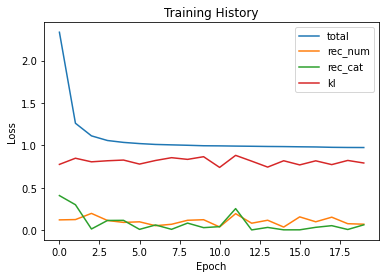

In [16]:
# Plot model loss/training progress
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss_num'])
plt.plot(history.history['reconstruction_loss_cat'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec_num","rec_cat","kl"], loc="upper right")
plt.show()

## Testing

Latent Variable: 0
Mean: -0.02817428670823574
Variance: 1.1825989484786987



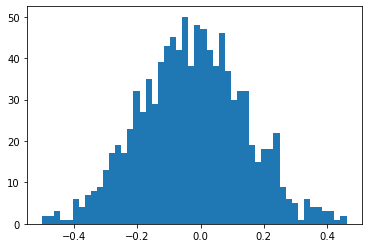

Latent Variable: 1
Mean: -0.06585665792226791
Variance: 1.0930804014205933



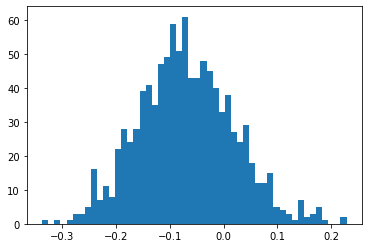

Latent Variable: 2
Mean: -0.14315980672836304
Variance: 1.1482656002044678



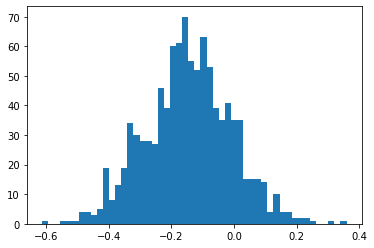

Latent Variable: 3
Mean: 0.03860165551304817
Variance: 1.1999354362487793



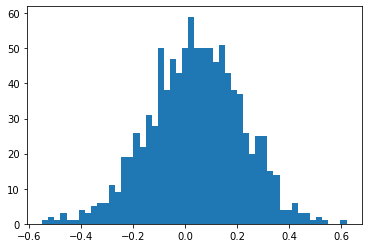

In [17]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Record the posterior trained distributions for z
latent_means = []
latent_vars = []

# Determine the average values for the mean/logvariance of the latent variables
for i in range(0, LATENT_DIM):
    epsilon = np.random.normal(loc=0, scale=1, size=1000)
    avg_mean = np.mean(z_mean[:,i])
    latent_means.append(avg_mean)
    avg_var = np.exp(np.mean(z_logvar[:,i]))
    latent_vars.append(avg_var)
    print(f"Latent Variable: {i}")
    print(f"Mean: {avg_mean}")
    print(f"Variance: {np.exp(avg_var)}\n")
    samples = avg_mean + (avg_var * epsilon)
    plt.hist(samples, bins=50)
    plt.show()

In [18]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 0.13220997154712677
Categorical Variable Loss: 0.09648620337247849


In [19]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_pers_test.inverse_transform(results[0])
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for x in results[1]:
        result = np.argmax(x, axis=1) + 1
        results_df[f"{x}"] = result

    current = CAT_IDX
    # Argmax for each categorical variable the test data
    for x in CAT_LENGTHS:
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{x}"] = test_data_cat
        current += x
else:
    # Handle case where there are no categorical variables
    results_num = scaler_pers_test.inverse_transform(results)
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

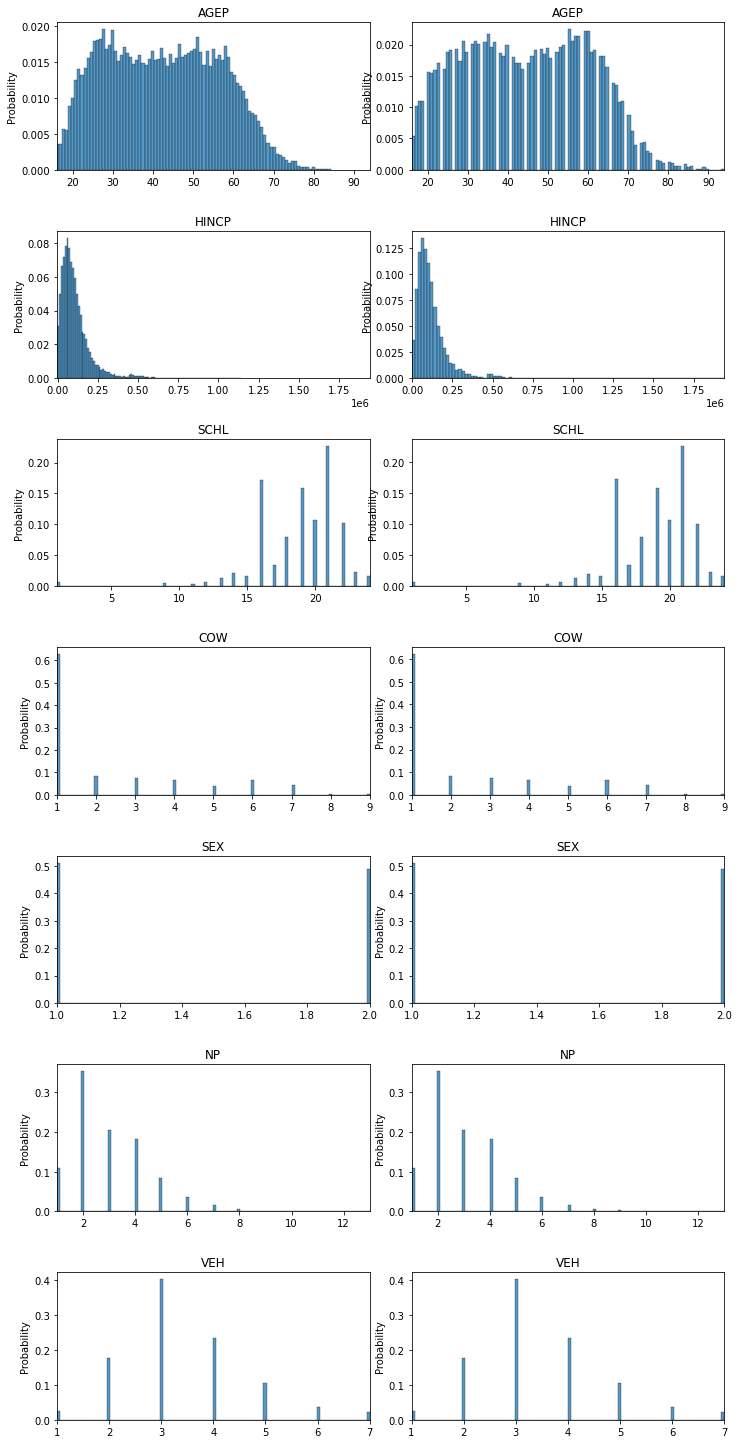

In [20]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,20))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [21]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')

# How many synthetic households to fill
POP_SIZE = len(synth_hh_df)

# How many variables represent each household
HH_DIM = 3

# Create new column for copy of hh sizes and scale household input variables
sizes = synth_hh_df[['NP']]
synth_hh_df = pd.concat([synth_hh_df, sizes], axis=1)
synth_hh_df.iloc[:,:HH_DIM] = scaler_hh_test.fit_transform(synth_hh_df.iloc[:,:HH_DIM])
synth_hh_df.columns = ['HINCP','NP','VEH','SIZE']

# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['SIZE']))
z = synth_hh_df[['HINCP','NP','VEH']].values

# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(len(z), LATENT_DIM))
inputs = np.concatenate((epsilon, z), axis=-1)

In [22]:
# start_time = time.time()

In [27]:
# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict(inputs[0:1000000,:])

MemoryError: Unable to allocate 68.7 MiB for an array with shape (1000000, 18) and data type float32

In [ ]:
# print(f"--- {time.time() - start_time} seconds ---")

In [ ]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_pers_test.inverse_transform(results[0])
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for x in results[1]:
        result = np.argmax(x, axis=1) + 1
        results_df[f"{x}"] = result
    current = CAT_IDX

    # Argmax for each categorical variable the test data
    for x in CAT_LENGTHS:
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{x}"] = test_data_cat
        current += x
else:
    # Handle case where there are no categorical variables
    results_num = scaler_pers_test.inverse_transform(results)
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

# Add back household ids to the results
results_df['HH_ID'] = synth_hh_df['HH_ID'].values

In [ ]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,20))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

In [ ]:
# Save the synthesized persons
results_df.to_csv('data/synthetic_populations/wa_persons.csv', index=False)
results_df